Simple TensorFlow image classification model based on [this tutorial](https://www.tensorflow.org/tutorials/images/classification).

In [1]:
# if you have to install tensorflow, idk if opencv-python is needed
# ! pip install tensorflow opencv-python

In [1]:
import tensorflow as tf

In [2]:
# tf automatically labels the data based on the folder name
# and splits them into batches

batch_size = 32
img_height = 180
img_width = 180
data_dir = '../dataset'

# change label_mode to use sparse_categorical_crossentropy
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    label_mode = 'categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1756 files belonging to 5 classes.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + '/val',
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 441 files belonging to 5 classes.


In [4]:
class_names = train_ds.class_names
print(class_names)

['closterium', 'microcystis', 'nitzschia', 'non-algae', 'oscillatoria']


In [6]:
# this stuff allows the use of buffered prefetching to load images from disk without i/o blocking

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Rescaling

model = Sequential()

model.add(Rescaling(1./255,  input_shape=(img_height, img_width, 3)))

# # these layers are from the tutorial
model.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

# 5 classes
model.add(Dense(5, activation='softmax'))

In [8]:
# SparseCategoricalCrossentropy when there are two or more label classes
model.compile(
            optimizer='adam',
            loss = 'categorical_crossentropy',
            metrics=['accuracy']
        )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

In [9]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20, verbose=1)

Epoch 1/20
55/55 [==============================] - 16s 285ms/step - loss: 1.6338 - accuracy: 0.3901 - val_loss: 1.3704 - val_accuracy: 0.4172
Epoch 2/20
55/55 [==============================] - 15s 274ms/step - loss: 1.3540 - accuracy: 0.4072 - val_loss: 1.3666 - val_accuracy: 0.4172
Epoch 3/20
55/55 [==============================] - 15s 276ms/step - loss: 1.3653 - accuracy: 0.4180 - val_loss: 1.4161 - val_accuracy: 0.4172
Epoch 4/20
55/55 [==============================] - 15s 275ms/step - loss: 1.3497 - accuracy: 0.4066 - val_loss: 1.3899 - val_accuracy: 0.4172
Epoch 5/20
55/55 [==============================] - 15s 277ms/step - loss: 1.3481 - accuracy: 0.4157 - val_loss: 1.3634 - val_accuracy: 0.4172
Epoch 6/20
55/55 [==============================] - 15s 277ms/step - loss: 1.3493 - accuracy: 0.4180 - val_loss: 1.3604 - val_accuracy: 0.4172
Epoch 7/20
55/55 [==============================] - 15s 277ms/step - loss: 1.3414 - accuracy: 0.4180 - val_loss: 1.3702 - val_accuracy: 0.4172

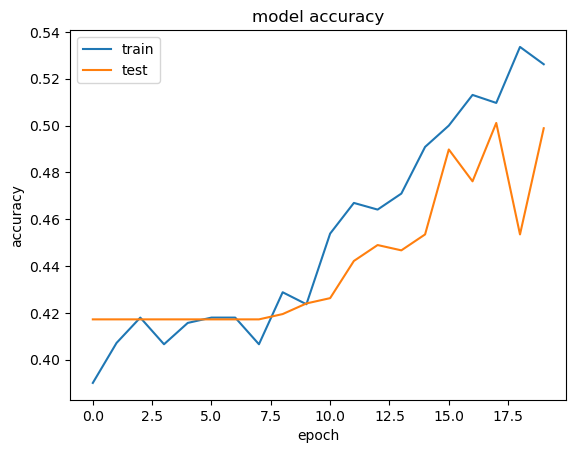

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

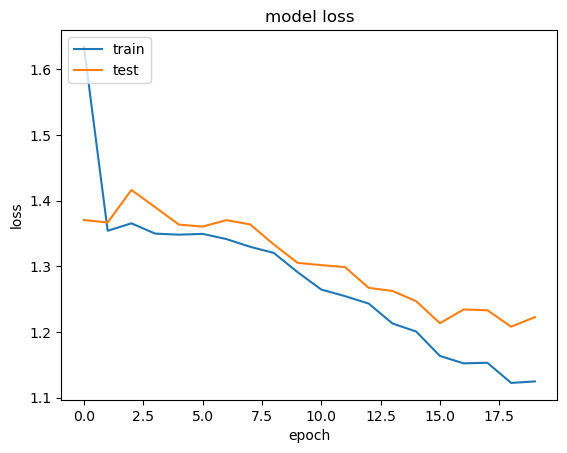

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# save the model to export
model.save("tf_model.h5")

# save the weights
model.save_weights("tf_model_weights.h5")

/Users/mateovelazquez/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model = tf.keras.models.load_model("tf_model.h5")

In [15]:
tf.saved_model.save(model, "tf_model")
!python -m tf2onnx.convert --saved-model tf_model --output "tf_model.onnx"
!zip -r tf_model.zip tf_model

INFO:tensorflow:Assets written to: tf_model/assets


INFO:tensorflow:Assets written to: tf_model/assets


<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2023-11-07 17:42:46,255 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2023-11-07 17:42:46,255 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-11-07 17:42:46,632 - INFO - Signatures found in model: [serving_default].
2023-11-07 17:42:46,633 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-11-07 17:42:46,633 - INFO - Output names: ['dense_1']
2023-11-07 17:42:46,633 - WARNING - Could not search for non-variable resources. Concrete function internal representation may have changed.
2023-11-07 17:42:46,896 - INFO - Using tensorflow=2.13.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-11-07 17:42:46,896 - INFO - Using opse

Convert model into ESP-DL